## Important Note:

This notebook requiers Java 23 with preview features because `rapaio-lib:7.0.1` is compiled with this version. To make that happen you need default java to be jdk 23 and the `kernel.json` to be updated in the following way:

    {
      "argv": [
        "java",
        "--enable-preview",
        "--add-modules",
        "java.base,jdk.incubator.vector",
        "-jar",
        "/home/ANT.AMAZON.COM/tutuianu/.local/share/jupyter/kernels/rapaio-jupyter-kernel/rapaio-jupyter-kernel-2.2.0.jar",
        "{connection_file}"
      ],
      "display_name": "Java (rjk 2.2.0)",
      "language": "java",
      "interrupt_mode": "message",
      "env": {
        "RJK_COMPILER_OPTIONS": "--enable-preview --release 23 --add-modules java.base,jdk.incubator.vector",
        "RJK_INIT_SCRIPT": "",
        "RJK_TIMEOUT_MILLIS": "-1"
      }
    }

The previous content is a sample from my local machine. Yours should be similar. What is added is `argv` lines from enable-preview till jdk.incubator.vector. Also the values for `RJK_COMPILER_OPTIONS`. Once you changed the kernel you can run this notebook with no issues.

# Rapaio darrays and some applications

In [3]:
%load ../../rapaio-bootstrap.ipynb

Adding dependency io.github.padreati:rapaio-lib:7.0.1
Solving dependencies
Resolved artifacts count: 1
Add to classpath: /home/ati/work/rapaio-jupyter-kernel/target/mima_cache/io/github/padreati/rapaio-lib/7.0.1/rapaio-lib-7.0.1.jar


## Brief introduction to darrays

### DArray creation

DArray is an in-memory implementation of multi-dimensional arrays. A DArray contains indexed elements of the same numerical type. Creation and other inner details regarding darray computations are giverned by DArrayManager. In order to create a darray we need to obtain an instance of a darray manager.

In [4]:
var dm = DArrayManager.base();
var dt = DType.DOUBLE;

Let's create a 3 dimensional darray which contains double values given in sequence.

In [5]:
var a = dm.seq(dt, Shape.of(2,3,4))

In [6]:
a

BaseStride{DOUBLE,[2, 3, 4],0,[12, 4, 1]}
[[[  0  1  2  3 ]   
  [  4  5  6  7 ]   
  [  8  9 10 11 ]]  
 [[ 12 13 14 15 ]   
  [ 16 17 18 19 ]   
  [ 20 21 22 23 ]]] 


Some comments about what information is presented in the output:

- The darray is a strided darray (stride arrays) which is managed by the base tensor factory. The default array implementation which uses Java flat arrays for storage and uses standard access array operations for data manipulation
- The values contained in that darray are of type double (64-bit floating point)
- the darray has a three dimensional shape, with dimension sizes given by `[2,3,4]`
- Values are stored at offset `0` and the strides have values `[12,4,1]`. This means that to find the next element in the first dimension, the tensor moves 12 positions relative to the current element. This also means that the last dimension moves fastest, and since the stride is unitary dense we can say it is stored in `C-order`.

The storage order can be specified at creation time. By default, the storage order is C-order.

In [11]:
var b = dm.seq(dt, Shape.of(2,3,4), Order.F);


They look the same, but flattening them in the storage order displays also how they are stored in reality.

In [25]:
b.ravel(Order.S)

BaseStride{DOUBLE,[24],0,[1]}
[ 0 12 4 16 8 20 1 13 5 17 9 21 2 14 6 18 10 22 3 15 ... ] 


### All tensors are views

The storage contains data elements from a tensor. Tensors are just objects which knows how to logically organize data based on data layout and how to perfom computations. But all tensors are views over a storage. One can check if the same storage lied beneath two tensors by comparing the storage objects.

In [26]:
b.storage() == b.ravel(Order.S).storage()

true

In [28]:
b.storage() == b.ravel(Order.C).storage()

false

Some operations can be performed without the need to copy data. Some other operations needs to create a new storage for data, either as a copy or as a new shaped storage. Read the documentation for each operation on how it works. We will take as an example the `sel` operation which selects a subset of a darray along a given dimension.

In [29]:
var a = dm.seq(dt, Shape.of(3,4));
a

BaseStride{DOUBLE,[3, 4],0,[4, 1]}
[[ 0 1  2  3 ]  
 [ 4 5  6  7 ]  
 [ 8 9 10 11 ]] 


We will take out the values from column with index 2 and remove (squeeze) the that dimension:

In [30]:
var b = a.selsq(1,2);
b

BaseStride{DOUBLE,[3],2,[4]}
[ 2 6 10 ] 


In [31]:
a.storage() == b.storage()

true

Notice how they have the same storage object. This is possible because using stride arithmetics we can create a view of the second column over the same storage, as such there is no need to copy the data. 

If we take some columns is scrumble order, the stride arithmetics would be impossible to derive, and a copy of the data will be created.

In [32]:
var b = a.sel(1, 3, 1, 2);
b

BaseStride{DOUBLE,[3, 3],0,[3, 1]}
[[  3 1  2 ]  
 [  7 5  6 ]  
 [ 11 9 10 ]] 


In [33]:
a.storage() == b.storage()

false

### In place operations vs copy on new operations

When possible, if it is possible, an in place operation can be performed. The convention is that those methods ends their name with `_` character. Take for example `log1p`

In [34]:
var a = dm.seq(dt, Shape.of(4,4));
a

BaseStride{DOUBLE,[4, 4],0,[4, 1]}
[[  0  1  2  3 ]  
 [  4  5  6  7 ]  
 [  8  9 10 11 ]  
 [ 12 13 14 15 ]] 


In [35]:
a.log1p()

BaseStride{DOUBLE,[4, 4],0,[4, 1]}
[[ 0                  0.6931471805599453 1.0986122886681096 1.3862943611198906 ]  
 [ 1.6094379124341003 1.791759469228055  1.9459101490553132 2.0794415416798357 ]  
 [ 2.1972245773362196 2.302585092994046  2.3978952727983707 2.4849066497880004 ]  
 [ 2.5649493574615367 2.639057329615259  2.70805020110221   2.772588722239781  ]] 


In [36]:
a.log1p().storage() == a.storage()

false

In [37]:
// in-place operation; the operation will affect the underlying tensor
a.log1p_()

BaseStride{DOUBLE,[4, 4],0,[4, 1]}
[[ 0                  0.6931471805599453 1.0986122886681096 1.3862943611198906 ]  
 [ 1.6094379124341003 1.791759469228055  1.9459101490553132 2.0794415416798357 ]  
 [ 2.1972245773362196 2.302585092994046  2.3978952727983707 2.4849066497880004 ]  
 [ 2.5649493574615367 2.639057329615259  2.70805020110221   2.772588722239781  ]] 


In [38]:
a

BaseStride{DOUBLE,[4, 4],0,[4, 1]}
[[ 0                  0.6931471805599453 1.0986122886681096 1.3862943611198906 ]  
 [ 1.6094379124341003 1.791759469228055  1.9459101490553132 2.0794415416798357 ]  
 [ 2.1972245773362196 2.302585092994046  2.3978952727983707 2.4849066497880004 ]  
 [ 2.5649493574615367 2.639057329615259  2.70805020110221   2.772588722239781  ]] 


# Applications of linear algebra

The darray component of rapaio library is not yet complete. The plan is to introduce new operations and new types of underlying implementations over them. But what it is it allowed to almost all the linear algebra operations used in various ML algorithms already implemented, like support vector machines, relevant vector machines, linear models, logistic regression, principal components and also in other places where linear algebra was found useful. This demonstrates that the implemented features for darrays should be enough to play with it and to show why linear algebra is an interesting topic.

Because of that, this demo will contain some things which can be done with linear algebra in practical situations.

# Solving a system of equations

Solving a system of equations is one of the oldest types of mathematical problems. To exemplify will will acually use one of those proposed problems.

The Rhind Papyrus is the source of most of our information about ancient Egyptian mathematics. 
This 5-meter-long papyrus contains 84 short mathematical problems, together with their solutions, and 
dates from about 1650 B.C. Problem 40 in this papyrus is the following:

> Divide 100 hekats of barley among five men in arithmetic progression so that the sum of the two smallest is one-seventh the sum of the three largest.

Let $a$ be the least amount that any man obtains, and let d be the term in the arithmetic progression. 
Then the quatities for the five men are: 

$a$, $a + d$, $a + 2d$, $a + 3d$, and $a + 4d$

The two conditions of the problem require that 
$$a + (a + d) + (a + 2d) + (a + 3d) + (a + 4d) = 100$$
$$\frac{1}{7} [(a + 2d) + (a + 3d) + (a + 4d)] = a + (a + d)$$
These equations reduce to the following system of two equations in two unknowns:
$$5a + 10d = 100$$
$$11a − 2d = 0$$

Their solution was based on an initial guess and later one by adjusting the solutions. They found the solutions as:
$$a = 5/3$$
$$d = 55/6$$

But this is a perfect case for linear algebra. We will solve it using LU decomposition as this:

In [19]:
var a = dm.stride(dt, Shape.of(2,2), Order.C, 5, 10, 11, -2);
var b = dm.stride(dt, Shape.of(2), Order.C, 100, 0);

In [20]:
a.lu().solve(b)

BaseStride{DOUBLE,[2],0,[1]}
[ 1.666666666666667 9.166666666666668 ] 


Let's check:

In [21]:
5./3

1.6666666666666667

In [22]:
55./6

9.166666666666666

LU decomposition is the usual workhorse for solving linear system. Also, it helps to determine if the system has solutions or not by computing the determinat. 

In [23]:
var a = dm.stride(dt, Shape.of(2,2), Order.C, 1, 1, 3, 3);
var b = dm.stride(dt, Shape.of(2), Order.C, 1, 4);

In [24]:
a.lu().solve(b)

EvalException: Matrix is singular.

If you want to avoid the exception, you can check with if the system has a solution with the following:

In [25]:
a.lu().isNonSingular()

false

In [26]:
a.lu().det()

-0.0

# Least squares

When we want to find a line which pass through multiple points, if there are more than two points we will probably have a problem. That is the system is overdetermined and no line can be found if not all the points are colinear. 

The method was invented by Legendre and Gauss, independently. Later on it was employed in statistics, mainly with the support of Gauss-Markov theorem. 

For illustration, we will use the data set created by Pearson, which contains height measurements of fathers and sons. It was used to see if there is a correlation between those heights.

In [39]:
var df = Datasets.loadPearsonHeightDataset();
var t = df.darray();
// print only the first rows
t.narrow(0, true, 0, 10)

BaseStride{DOUBLE,[10, 2],0,[2, 1]}
[[ 65   59.8 ]  
 [ 63.3 63.2 ]  
 [ 65   63.3 ]  
 [ 65.8 62.8 ]  
 [ 61.1 64.3 ]  
 [ 63   64.2 ]  
 [ 65.4 64.1 ]  
 [ 64.7 64   ]  
 [ 66.1 64.6 ]  
 [ 67   64   ]] 


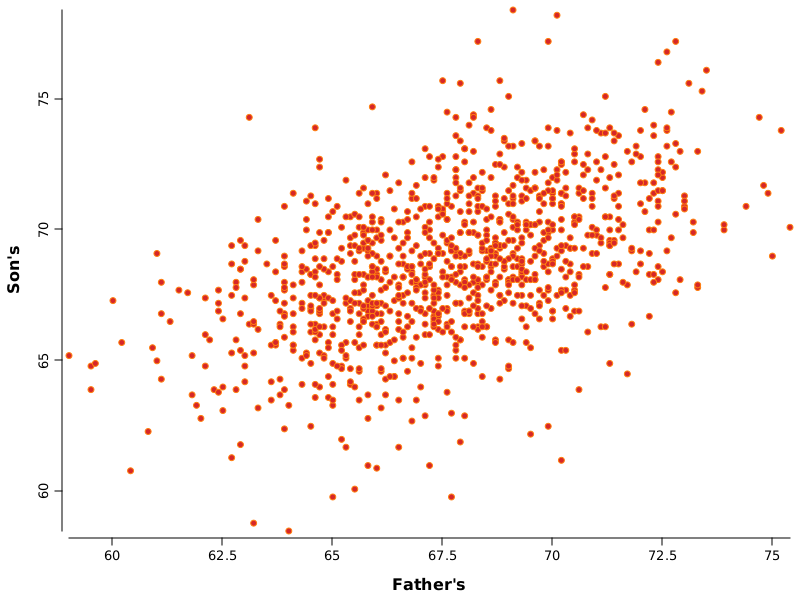

In [40]:
WS.image(points(t.selsq(1, 0).dv(), t.selsq(1,1).dv(), color(4), fill(1), pch.circleFull()).xLab("Father's").yLab("Son's"), 800, 600)

The solution consists in optimizing the sum of squares of the distances between the line and the data points. $Loss(\hat{y}, y) = (X^T\beta - y)^2$. Using the fact that the loss function is convex, the minimum is achieved when the derivative equals $0$. This leads to the well-known formulas called *normal equations*:
$$X^TX\beta = X^Ty$$
where $\beta$ is our coefficients of the line that we want to find.

What we do is that we want to regress father's height over son's heights. We also want to allow for the line to be required to cross origin. To do that we ammend the input with a column full of ones.

In [29]:
var len = t.dim(0);
len

1078

In [30]:
var X = dm.stack(1, List.of(dm.full(dt, Shape.of(len), 1.), t.selsq(1, 0)));
X.narrow(0, true, 0, 10)

BaseStride{DOUBLE,[10, 2],0,[2, 1]}
[[ 1 65   ]  
 [ 1 63.3 ]  
 [ 1 65   ]  
 [ 1 65.8 ]  
 [ 1 61.1 ]  
 [ 1 63   ]  
 [ 1 65.4 ]  
 [ 1 64.7 ]  
 [ 1 66.1 ]  
 [ 1 67   ]] 


In [31]:
var y = t.selsq(1,1);
y

BaseStride{DOUBLE,[1078],1,[2]}
[ 59.8 63.2 63.3 62.8 64.3 64.2 64.1 64 64.6 64 65.2 65.4 65.7 65.4 65.3 64.8 65 65.5 65.1 65.5 ... ] 


In [32]:
// left side
X.t_().mm(X)

BaseStride{DOUBLE,[2, 2],0,[2, 1]}
[[  1,078      72,966.4          ]  
 [ 72,966.4 4,946,984.2399999965 ]] 


In [33]:
// right side
X.t_().mv(y)

BaseStride{DOUBLE,[2],0,[1]}
[ 74,041.59999999999 5,015,814.79 ] 


In [34]:
// solve
var sol = X.t_().mm(X).qr().solve(X.t_().mv(y));
sol

BaseStride{DOUBLE,[2],0,[1]}
[ 33.89280054101943 0.5140059125403162 ] 


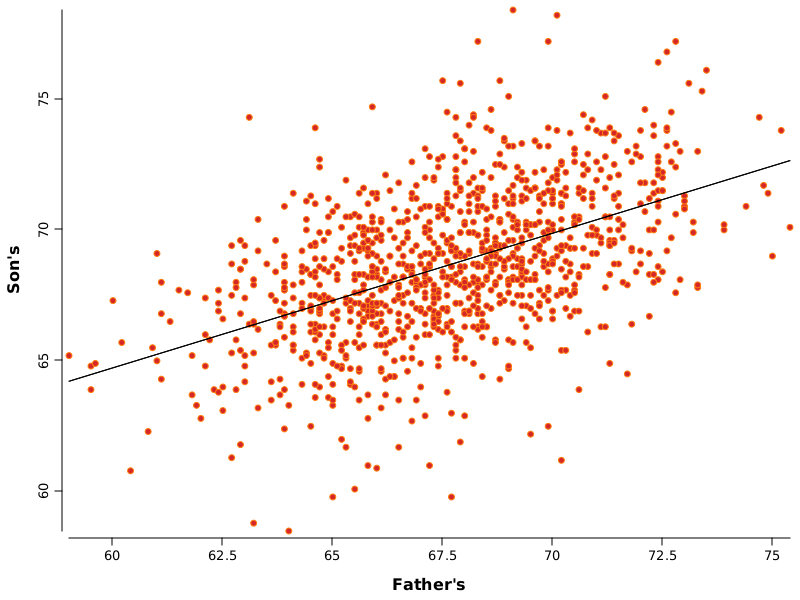

In [35]:
WS.image(
    points(t.selsq(1, 0).dv(), t.selsq(1,1).dv(), color(4), fill(1), pch.circleFull())
    .funLine(x -> sol.get(0) + x*sol.get(1))
    .xLab("Father's")
    .yLab("Son's"), 800, 600
);

# Image compression with PCA

While principal components were not built for image compression, they can also used for that purpose using some linear algebra tricks. In the following we will offer some intuition on principal components and how they can be used to data compression. 

For that purpose we will use a random image.

In [36]:
var bi = ImageTools.readImage(new URI(
    "https://img.freepik.com/free-photo/two-chicks-beach-ai-generated_268835-6148.jpg?w=1060&t=st=1706892885~exp=1706893485~hmac=1aa2364fe0170b12ec0004772ecb802c7eb596ff4a9b2cd780d151aaf8ab8eaf").toURL());

Let's see the image first.

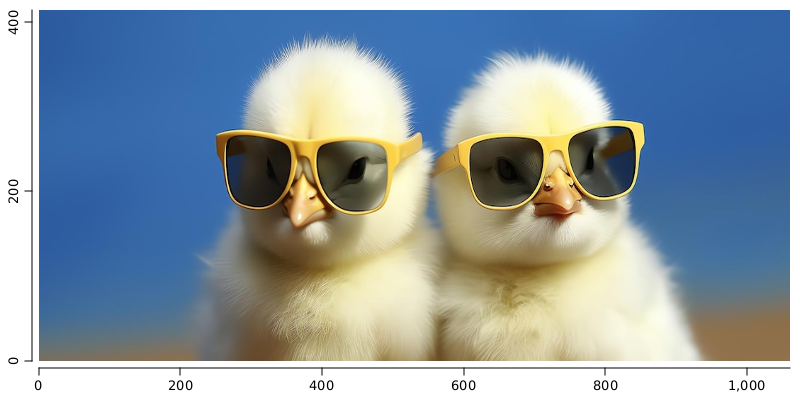

In [37]:
WS.image(image(bi), 800, 400)

Cool friends. We collect data from image in a tensor with 3 planes, one for each color. 

In [38]:
int m = bi.getWidth();
int n = bi.getHeight();
var img = dm.zeros(dt, Shape.of(n, m, 3));
for (int i = 0; i < m; i++) {
    for (int j = 0; j < n; j++) {
        int clr = bi.getRGB(i, j);
        img.setDouble((clr & 0x00ff0000) >> 16, j, i, 0);
        img.setDouble((clr & 0x0000ff00) >> 8, j,i, 1);
        img.setDouble(clr & 0x000000ff, j,i, 2);
    }
}
img.shape();

Shape: [415,1060,3]

The procedure could be applied for each color plane. We will avoid that for simplification, as such we will use a single data plane. We transform the image into a black-white one simply by averaging along color planes. This is easy to do and leave use with a matrix.

Shape: [415,1060]

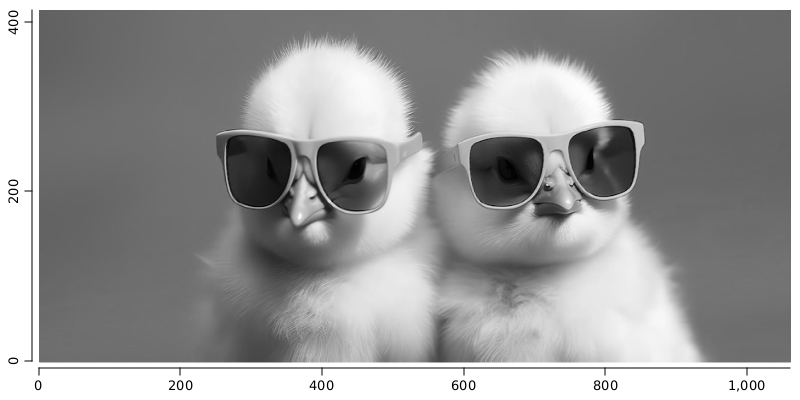

In [39]:
var bw = img.mean1d(2);
display(bw.shape());
WS.image(matrix(bw, palette.bw(0, 255)), 800, 400);

PCA (principal component analysis) is a technique which basically consists in a series of rotations. The purpose of those rotations is than after they are applied over data, the variance of data over the first axis is the highest, followed by the variance on the second axis and so on. Additionally, those components are orthogonal, and more than that, it can be shown that they corresponds to eigenvectors of covariance matrix. 

Those rotations have the application point in origin. Because of this, we need to centralize data before finding components. To give a fair evaluation of their importance (contribution to variance), an usual thing is to scale them so they have the same standard deviation.

In [40]:
// compute the mean and standard deviation along columns
var mean = bw.mean1d(1).stretch(1);
var std = bw.std1d(1, 1).stretch(1);

In [41]:
// create a standardized version of data using broadcast operations
var c = bw.sub(mean).div(std);
c.shape()

Shape: [415,1060]

We compute the covariance matrix $X^TX$ on the standardized data. Then we compute the eigen value decomposition. Note that to compute eigen values one can use also svd decomposition directly on standardized matrix. This avoid some computation. We follow the classic path for illustrative porposes.

In [42]:
var cov = c.t_().mm(c);
cov.shape()

Shape: [1060,1060]

In [43]:
var eig = cov.eig()

Each decomposition available in library returns an object which contains various artifacts of the specific decomposition. In our case we can collect eigen values  with real and imaginary part (if it's the case), eigen vectors, and also a diagonal matrix with eigen values.

We don't have complex values on eigen values because we compute them over the covariance matrix. Covariance matrix is a symmetric positive semi-definite matrix, and those kind of matrices does not produce complex eigen values. For illustartive purposes we display them below.

In [44]:
eig.real()

BaseStride{DOUBLE,[1060],0,[1]}
[ 189,398.80305584273 101,548.2645775437 51,171.3046202222 23,100.816827320774 16,703.655652595222 10,433.68534300146 8,006.545542029998 4,301.788079126666 3,770.644628740355 3,206.623381772559 2,770.036794947505 2,057.8313084768547 1,819.730987878407 1,529.7546040640152 1,354.1608402214638 1,120.1266052953083 1,063.6755448662739 914.2570954249896 879.5797357193267 864.599956164157 ... ] 


In [45]:
eig.imag()

BaseStride{DOUBLE,[1060],0,[1]}
[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... ] 


We worked to organize the original data onto orthogonal directions with decreasing prejected variance. Why all that? The point is that we can split the whole information contained into the original matrix into pieces which correspond to those components. 

Using those pieces, we can reduce the original dimensionality of the data using only some of the whole pieces, in the hope that those components retain enough information. This is is dimensionality reduction and can be acheved by using instead of our matrix $X$, a reduced matrix $XV$, where $V$ contains only the eigen vectors corresponding with the largest covered variance. Thus, instead of working with a design matrix of size $n x m$, where $m$ is the number of features we work with a design matrix of dimension $n x p$, where $p < m$ is the number of selected eigen vectors.

If, on the other hand, we want to return in the original space of the matrix, we continue to multiply with $V^T$, thus obtaining a shape of the original matrix $m x n$. The meaning of $XVV^T$ is a matrix of the same shape as $X$, but which contains only the information corresponding to the selected components. 

The whole process consists in the following steps:
- centralize and scale the input matrix $X$ -> $C$
- cumpute decreasing eigen vectors of covariance
- select a number of eigen vectors
- retain only information corresponding with selected eigen vectors using:

    * subtract mean, divide by std
    * multiply with $V$ and $V^T$
    * multiply with std and add mean


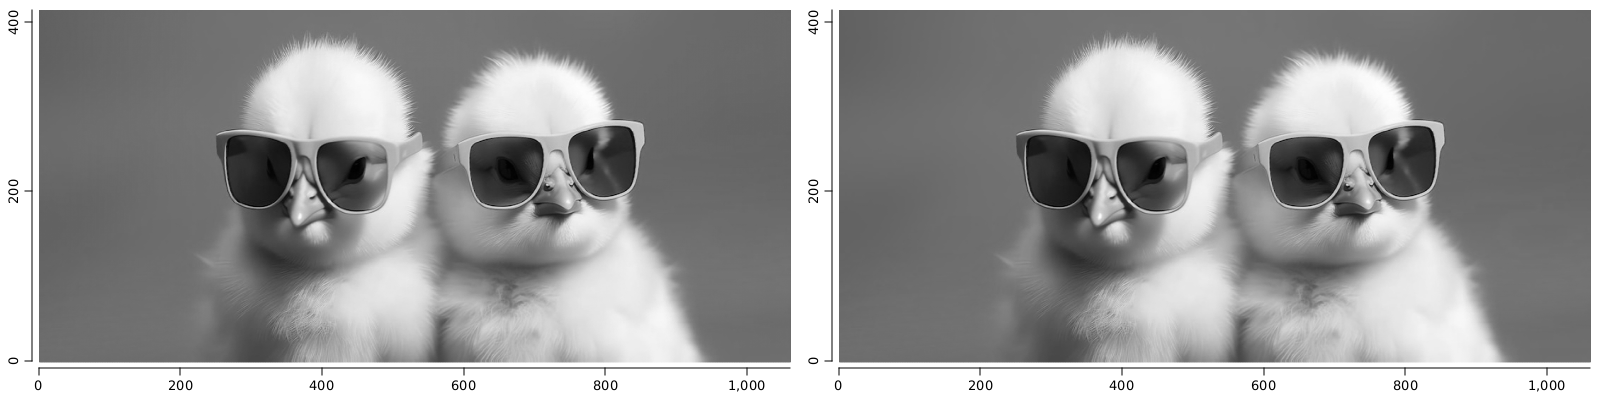

In [46]:
var v = eig.v();
var reduced = bw.sub(mean).div(std).mm(v).mm(v.t_()).mul(std).add(mean);
WS.image(gridLayer(1, 2).add(matrix(reduced, palette.bw(0, 256))).add(matrix(bw, palette.bw(0, 255))), 1600, 400);

In the left side we have the recovered image which uses all eigen vectors and in the right side we have the original image. There is no difference. There is no numerical difference, they not only look similar, they are identical up to some numerical computing errors.

What happens if we decide to use only a limited number of eigen vectors? The original number of eigen vectors is 1060.

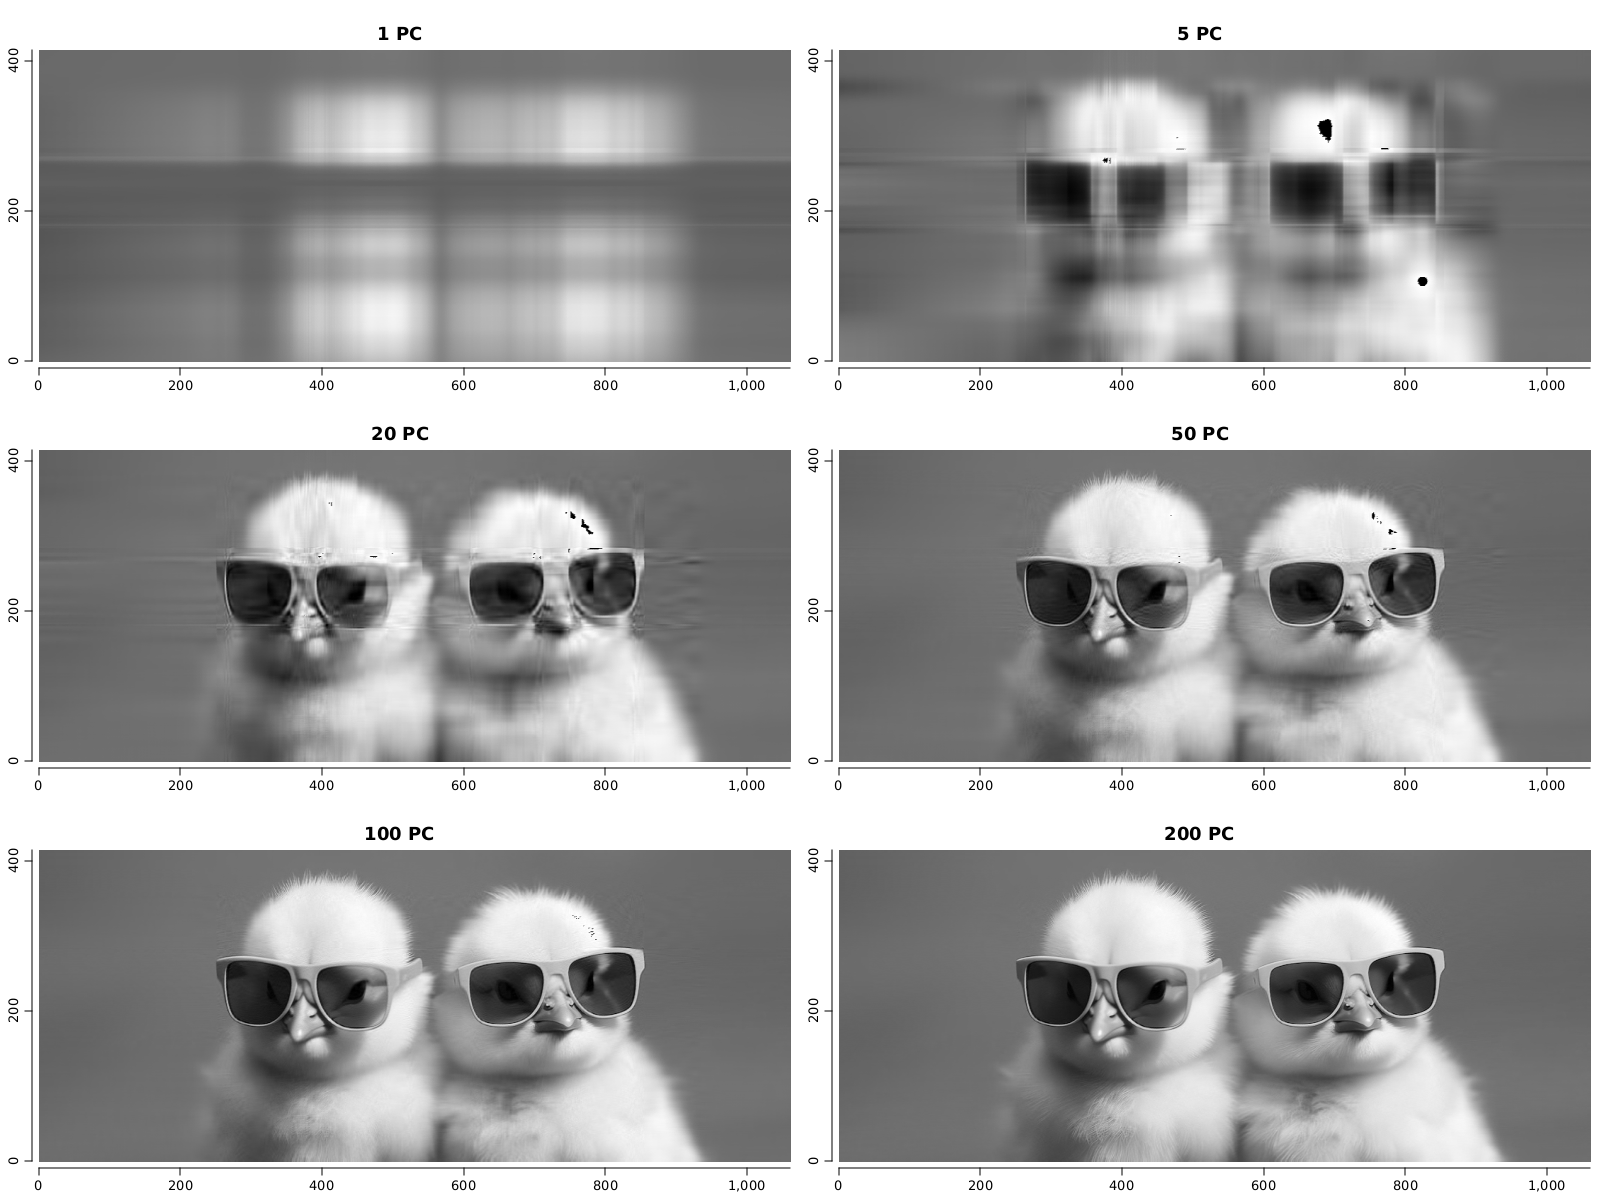

In [47]:
Function<Integer, DArray<Double>> fun = n -> bw.sub(mean).div(std).mm(v.narrow(1, true, 0, n)).mm(v.narrow(1, true, 0, n).t_()).mul(std).add(mean);
WS.image(gridLayer(3, 2)
         .add(matrix(fun.apply(1), palette.bw(0, 256)).title("1 PC"))
         .add(matrix(fun.apply(5), palette.bw(0, 256)).title("5 PC"))
         .add(matrix(fun.apply(20), palette.bw(0, 256)).title("20 PC"))
         .add(matrix(fun.apply(50), palette.bw(0, 256)).title("50 PC"))
         .add(matrix(fun.apply(100), palette.bw(0, 256)).title("100 PC"))
         .add(matrix(fun.apply(200), palette.bw(0, 256)).title("200 PC"))
         , 1600, 1200);

The progression is amazing. With one component we have just some light bluring. With 5 components we understand we have two characters. 20 components gives us the understanding of the characters, but in poor quality. 50 components is a refinement, acceptable quality. 100 components we have almost everything, other than some detail artifacts. 200 components is totally acceptable as quality. 200 of over 1000 components, 20% of the whole data.

A question might arise, still, how can we save information. To get the image we have to save original $X$, a part of eigen vectors called $V_p$, the $mean$ and $std$. Where is the catch, since there is much more data than initially. The point is that don't need to store them is that form. Actually we know that we will multiply them. We use the following trick:

Instead of $X$ and $V_p$ to compute $XV_pV^T_p$, we store $XV_p$ and $V_p$. $XV_p$ after multiplication will have size $n x p$, less than $n x m$. If $p$ is much lessar than $m$ we can save plenty. For illustration, in our case instead of saving $X = 415*1060 = 440960$ we store $XV_p = 415 * 200 = 83200$ adding to that $V_p = 1060 * 200 = 212000$ is still much less than half of the original data.

# Other operations with darrays

The are many methods implemented already. Still, much more are probably not. I will implement them when there will be a need. You can also ask for something which is missing. Until then, we will present some things which you could find interesting.

A first aspect is related with the fact that all tensors are views over data storage. This might look strange at the first sight, especially when one compares with numpy which distincts between arrays and views. I see no reason to separate those. As a consequence, when you are workig with data layout manipulation operations, if stride arithmetics applies, no new copies of the data will be created.

In [41]:
Random random = new Random(42);
var a = dm.random(dt, Shape.of(20, 5), random);
a

BaseStride{DOUBLE,[20, 5],0,[5, 1]}
[[  0.6054611363173034    0.47673188281383294 -0.49948335406718436 -0.5915425111590309   0.42765530257204803 ]  
 [  1.3010087179670164   -0.3350785583251401  -0.5955196938503862  -0.09123338065574725  0.7820308518899145  ]  
 [  1.400564194820624    -0.15987194503778307  0.6741945446522577  -0.28827825790751316 -0.9254017750976883  ]  
 [  0.2387490522334931   -0.8072279983731828   0.9383428291093232  -0.9454368915500337   0.22093218517194996 ]  
 [  0.6785245136052881    0.17902343157217976  0.20195714004769655  0.6824094169904458  -1.8603467900546857  ]  
 [ -0.3640243331383754    0.9070012459953166  -0.20781285678089798  1.9437248772714735   0.5633633559555993  ]  
 [ -0.04871172331592452  -0.5485519117080085   1.643499006763654    0.9172410254747001   0.349504085373619   ]  
 [ -0.3341809901539511   -0.3577776057925789  -0.16451953409234601 -0.10719511736576721 -0.0685135403645662  ]  
 [ -0.07772721992835083   0.9436370508097213  -1.03201923008

There are various functions which aggregates data. For illustration purposes we can consider a matrix. Aggregating data along a dimension in a matrix produces a vector which contains one value for each row or column in the matrix. If we aggregate along columns, it means each column from the matrix is transformed into a single value, thus in the end we will obtain a vector of values. If we aggregate along rows, than we will get a vector with one value for each column.

In [49]:
// compute minimum value along rows
a.amin1d(0)

BaseStride{DOUBLE,[5],0,[1]}
[ -0.5863436478398663 -1.9218206218596519 -1.7930243327862754 -1.9263576324867564 -1.8603467900546857 ] 


Those operations can be used to transform data for various purposes. Let's do the following. Transform all columns into scaled versions of the form:
$$a[i,j] = \frac{a[i,j] + min_j}{max_j - min_j}$$
where j is the column index, and i is the row index. This scales linearly all the values to be into unit interval. The following command does that:

In [50]:
var s = a.sub(a.amin1d(0)).div(a.amax1d(0).sub(a.amin1d(0)));
s

BaseStride{DOUBLE,[20, 5],0,[5, 1]}
[[ 0.5998289193731958   0.6896269138476709  0.34302301186472545 0.3449061145239287  0.8658876219308791  ]  
 [ 0.9498942654933096   0.4562168350350755  0.31755596052050056 0.4741822034036303  1                   ]  
 [ 1                    0.5065918823903597  0.6542605639803702  0.4232672999732961  0.3538271744794756  ]  
 [ 0.41526470546744215  0.32046539303795213 0.7243077767119585  0.2534624878057192  0.7876538698287515  ]  
 [ 0.6366013230646284   0.6040303884198903  0.5290319863723814  0.6740856410423601  0                   ]  
 [ 0.11189211191788492  0.8133370817409697  0.4203686036142013  1                   0.9172459331841032  ]  
 [ 0.27058724767226594  0.39483941277923806 0.9113020813945426  0.7347643495433126  0.8363115250256254  ]  
 [ 0.12691210546950518  0.44969045130082297 0.4318491876749893  0.4700578115670808  0.6781139914472857  ]  
 [ 0.25598390473433974  0.8238705334628961  0.2018044009959772  0.748282310925952   0.66632598501705

Let's sort the values along columns:

In [51]:
// sorting in-place along rows
s.sort_(0, true)

BaseStride{DOUBLE,[20, 5],0,[5, 1]}
[[ 0                    0                   0                   0                   0                   ]  
 [ 0.002617385783434293 0.2416747949661516  0.12468816074076097 0.12955865618995888 0.27100076248478666 ]  
 [ 0.052861984420037915 0.30640650913947987 0.1301992313869794  0.2534624878057192  0.3442254008365238  ]  
 [ 0.11189211191788492  0.32046539303795213 0.2018044009959772  0.3449061145239287  0.3538271744794756  ]  
 [ 0.12691210546950518  0.39483941277923806 0.23200371659685504 0.373520504176245   0.5399843777893801  ]  
 [ 0.12943236665202884  0.4063778454164334  0.24862347733431256 0.4232672999732961  0.5828150613046608  ]  
 [ 0.16207224893906402  0.44969045130082297 0.31755596052050056 0.4530437047398968  0.6663259850170561  ]  
 [ 0.19474250233732684  0.4562168350350755  0.34302301186472545 0.4700578115670808  0.6781139914472857  ]  
 [ 0.24886415557047112  0.5065918823903597  0.39016515940122654 0.4741822034036303  0.69131989434937

Too many numbers, we should plot them to have some idea

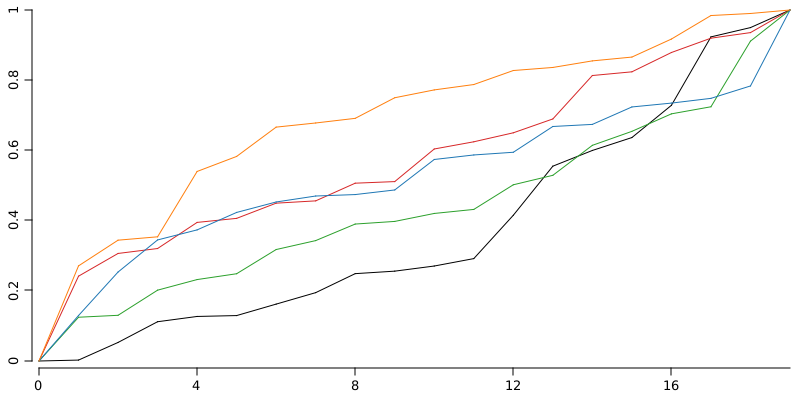

In [52]:
var p = plot();
for(int i=0; i<s.dim(1); i++)
    p.lines(s.selsq(1,i).dv(), color(i));
WS.image(p, 800, 400)

Aggregation works not only for matrices, but for general darrays. It would be more difficult to visualise them, but we can illustrate with an example.

In [42]:
var t = dm.seq(dt, Shape.of(4, 4, 4));
t

BaseStride{DOUBLE,[4, 4, 4],0,[16, 4, 1]}
[[[  0  1  2  3 ]   
  [  4  5  6  7 ]   
  [  8  9 10 11 ]   
  [ 12 13 14 15 ]]  
 [[ 16 17 18 19 ]   
  [ 20 21 22 23 ]   
  [ 24 25 26 27 ]   
  [ 28 29 30 31 ]]  
 [[ 32 33 34 35 ]   
  [ 36 37 38 39 ]   
  [ 40 41 42 43 ]   
  [ 44 45 46 47 ]]  
 [[ 48 49 50 51 ]   
  [ 52 53 54 55 ]   
  [ 56 57 58 59 ]   
  [ 60 61 62 63 ]]] 


In [43]:
t.sum1d(0)

BaseStride{DOUBLE,[4, 4],0,[4, 1]}
[[  96 100 104 108 ]  
 [ 112 116 120 124 ]  
 [ 128 132 136 140 ]  
 [ 144 148 152 156 ]] 


In [44]:
t.sum1d(1)

BaseStride{DOUBLE,[4, 4],0,[4, 1]}
[[  24  28  32  36 ]  
 [  88  92  96 100 ]  
 [ 152 156 160 164 ]  
 [ 216 220 224 228 ]] 


In [45]:
t.sum1d(2)

BaseStride{DOUBLE,[4, 4],0,[4, 1]}
[[   6  22  38  54 ]  
 [  70  86 102 118 ]  
 [ 134 150 166 182 ]  
 [ 198 214 230 246 ]] 


# What else?

There are many other applications of linear algebra and it is impossible to cover them, even in slightest. Linear algebra emerges in many places, as soon as one wants to work with multiple dimensions. This is not in any case an apology for linear algebra, it would be a useless try for an already won fight. I tried to cover some of them in order to test and stress a little the implementation I made for that library. 

There are many things which can be added and I hope it will happen as soon as possible. Still, I think it passed a live smoke test and I feel content that useful things can be done with them. Hope you enjoyed too, I really did. And if you have ideas and you have no fear to get your hands dirty you are welcome to contribute!